In [14]:
%matplotlib nbagg
import pandas as pd
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout, Masking
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import LSTM, SimpleRNN
from keras.layers.advanced_activations import PReLU
import numpy as np

from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook

import matplotlib.pyplot as plt

from normalize import normalize

import plotly.plotly as py
from plotly.graph_objs import *

In [2]:
trainBuffer = np.loadtxt('dataFinal111.csv')

In [3]:
#set and normalize train/test data


teststart = 1
teststop = 6


days1 = 1586
batch_size1 = 1586
dim = 36
tsteps1 = days1 / batch_size1 * 24

#trainBuffer = res.as_matrix().T

train = np.reshape(trainBuffer, (batch_size1, tsteps1, dim))
train[0, 1, :]

array([-0.77394475, -1.43720269, -1.43717528, -0.31072365, -0.71496893,
       -1.39856175, -1.43717528, -0.7630256 ,  0.47540001, -0.67256629,
       -0.67599814, -0.43416186, -0.31472601, -0.14891923, -0.33546281,
       -0.33111845, -0.70699757, -0.58892497, -0.47197658, -0.91611418,
       -1.        , -1.        ,  1.        ,  0.        , -0.64785306,
       -1.21750078, -0.87571215, -0.81874738, -0.87571215, -0.81874738,
       -0.7617826 , -0.7617826 , -1.04660646, -0.81874738, -1.44535987,
       -1.51686175])

In [4]:
aa = train.flatten()
bb = np.delete(aa, range(0, dim))
bb = np.concatenate((bb, np.array(aa[0:dim])), axis=0)
train_Y = np.reshape(bb, (batch_size1, tsteps1, dim))
train_Y = train_Y[:, :, 0:20]

In [5]:
testDaySize = 6

test = train[-10:, :, :] #take the last 10 days as the test set
train = train[0:-testDaySize, :, :]

In [6]:
batch_size1 = 158
tsteps1 = train.shape[0] / batch_size1 * 24

train = np.reshape(train, (batch_size1, tsteps1, dim))
test = np.reshape(test, (1, tsteps1, dim))

In [7]:
#set and normalize train/test label


testDaySize = 6

test_Y = train_Y[-10:, :, :]
train_Y = train_Y[0:-testDaySize, :, :]

In [8]:
batch_size1 = 158
tsteps1 = train_Y.shape[0] / batch_size1 * 24

train_Y = np.reshape(train_Y, (batch_size1, tsteps1, 20))
test_Y = np.reshape(test_Y, (1, tsteps1, 20))

In [9]:
train[0, 3, :]

array([-1.2711335 , -1.85710885, -1.85710963, -1.37924244, -1.3856224 ,
       -1.83949058, -1.85710963, -1.32233963, -0.11087986, -0.89286497,
       -1.46803597, -1.2359277 , -1.2031165 , -1.02601196, -1.0668978 ,
       -1.25453895, -1.53754219, -1.37648161, -1.11811697, -1.44938946,
       -1.        , -1.        ,  1.        ,  0.        , -0.93267692,
       -1.55928941, -1.21750078, -1.16053601, -1.04660646, -1.10357124,
       -0.98964169, -1.33143032, -1.27446555, -1.04660646, -1.55928941,
       -1.2279357 ])

In [10]:
train_Y[0, 2, :]

array([-1.2711335 , -1.85710885, -1.85710963, -1.37924244, -1.3856224 ,
       -1.83949058, -1.85710963, -1.32233963, -0.11087986, -0.89286497,
       -1.46803597, -1.2359277 , -1.2031165 , -1.02601196, -1.0668978 ,
       -1.25453895, -1.53754219, -1.37648161, -1.11811697, -1.44938946])

In [28]:
def myplot(y, trueLabel, start):
    for i in range(start, start + 4):

        plt.subplot(2, 2, i + 1 - start)
#         plt.plot(y[:, 24 * 1: 24 * 6, i].flatten(), 'b', 
#                  trueLabel[:, 24 * 1: 24 * 6, i].flatten(), 'g', linewidth=2.0)
#         #plt.plot(y[:, :, i].flatten(), 'b', trueLabel[:, :, i].flatten(), 'g')
#         title = 'zone {}'.format(i + 1)
#         plt.title(title)
#         #plt.ylabel('Damped oscillation')
        line1, = plt.plot(y[:, 24 * teststart: 24 * teststop, i].flatten(), 'r', label="pred", linewidth=2)
        line2, = plt.plot(trueLabel[:, 24 * teststart: 24 * teststop, i].flatten(), 'b', label="true", linewidth=2)
        title = 'zone {}'.format(i + 1)
        plt.title(title)

        # Create a legend for the first line.
        first_legend = plt.legend(handles=[line1], loc=1)

        # Add the legend manually to the current Axes.
        ax = plt.gca().add_artist(first_legend)

        # Create another legend for the second line.
        plt.legend(handles=[line2], loc=2)

    plt.tight_layout()
    plt.show()

In [11]:
#build nerual network

ts = Sequential()
ts.add(Masking(mask_value=0., input_shape=(tsteps1, 36)))
ts.add(TimeDistributed(Dense(output_dim=200, activation='linear'), input_shape=(tsteps1, 36)))
#ts.add(PReLU())
#ts.add(Dropout(0.4))
#ts.add(LSTM(100, batch_input_shape=(60, 24, 20), activation='relu', 
#            inner_activation='relu', return_sequences=True, stateful=True))
ts.add(LSTM(output_dim=500,
           input_shape=(tsteps1, 200),
           dropout_W = 0.4,
           return_sequences=True))
ts.add(LSTM(output_dim=200,
           input_shape=(tsteps1, 500),
           dropout_W = 0.4,
           return_sequences=True))
#ts.add(Dropout(0.4))
ts.add(TimeDistributed(Dense(output_dim=20, activation='linear'), input_shape=(tsteps1, 200)))
#ts.add(PReLU())

ts.compile(loss='mse', optimizer='rmsprop')

In [12]:
#train the nerual network

epochs1 = 80

ts.fit(train,
        train_Y,
          verbose=1,
          nb_epoch=epochs1)

/Users/king/anaconda/lib/python2.7/site-packages/Keras-1.0.0-py2.7.egg/keras/backend/theano_backend.py:484: UserWarning:

theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 3 is not part of the computational graph needed to compute the outputs: keras_learning_phase.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.



Epoch 1/40
158/158 [==============================] - 14s - loss: 0.7087    
Epoch 2/40
158/158 [==============================] - 14s - loss: 0.4860    
Epoch 3/40
158/158 [==============================] - 14s - loss: 0.4355    
Epoch 4/40
158/158 [==============================] - 14s - loss: 0.4386    
Epoch 5/40
158/158 [==============================] - 15s - loss: 0.4016    
Epoch 6/40
158/158 [==============================] - 14s - loss: 0.4042    
Epoch 7/40
158/158 [==============================] - 14s - loss: 0.3778    
Epoch 8/40
158/158 [==============================] - 14s - loss: 0.3712    
Epoch 9/40
158/158 [==============================] - 14s - loss: 0.3624    
Epoch 10/40
158/158 [==============================] - 14s - loss: 0.3710    
Epoch 11/40
158/158 [==============================] - 13s - loss: 0.3548    
Epoch 12/40
158/158 [==============================] - 14s - loss: 0.3364    
Epoch 13/40
158/158 [==============================] - 14s - loss: 0.3333

In [14]:
y = ts.predict(train)

/Users/king/anaconda/lib/python2.7/site-packages/Keras-1.0.0-py2.7.egg/keras/backend/theano_backend.py:484: UserWarning:

theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 1 is not part of the computational graph needed to compute the outputs: keras_learning_phase.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.



In [19]:
yprint0 = y[:, :, 0].flatten()
yprint1 = train_Y[:,:, 0].flatten()
trainprint1 = train[:,:, 0].flatten()

plt.plot(yprint0, 'b', yprint1, 'r', trainprint1, 'g')
#plt.plot(yprint0, 'b')
#plt.plot(yprint1, 'r')
plt.show()

In [23]:
zoneNum = 17
yprint0 = y[0, :, zoneNum].flatten()
yprint1 = train_Y[0,:, zoneNum].flatten()
trainprint1 = train[0,:, zoneNum].flatten()

plt.plot(yprint0, 'b', yprint1, 'r', trainprint1, 'g')
plt.show()

In [57]:
trace0 = Scatter(
  y= np.reshape(trainLabel_norm.normedData[:,:, 0:1], (1580 * 24))
)
trace1 = Scatter(
  y=np.reshape(y[:, :, 0:1], (1580 * 24))
)
data = Data([trace0, trace1])

py.iplot(data, filename = 'basic-line')

The draw time for this plot will be slow for all clients.


In [ ]:
test1 =  train_norm.cal(test)
test_Y1 = trainLabel_norm.cal(test_Y)


y = ts.predict(test1)

ypred = y[:,:, 11:12].flatten()
ystandard = test_Y1[:,:, 11:12].flatten()


plt.plot(ypred, 'b', ystandard, 'g')
plt.show()

In [13]:
#prediction process

test1 = np.zeros(test.shape)
test1.astype(float)

test1[:, 0:24*6, :] =  test[:, 0:24*6, :]


for i in range(24*6 + 1, 240):
    y = ts.predict(test1)
    test1[:, i, :] = np.concatenate((y[:, i - 1, :], test[:, i, 20:]), axis=1)

/Users/king/anaconda/lib/python2.7/site-packages/Keras-1.0.0-py2.7.egg/keras/backend/theano_backend.py:484: UserWarning:

theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 1 is not part of the computational graph needed to compute the outputs: keras_learning_phase.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.



In [18]:
np.savetxt('test_Y', test_Y[0, 24 * teststart: 24 * teststop, :], delimiter=',')
np.savetxt('y', y[0, 24 * teststart: 24 * teststop, :], delimiter=',')

In [17]:
test_Y.shape

(1, 240, 20)

In [34]:
zone = 4
plt.plot(y[:, 24 * teststart: 24 * teststop, zone].flatten(), 'r', test_Y[:, 24 * teststart: 24 * teststop, zone].flatten(), 'b', linewidth=2)
plt.show()

In [25]:
def error(y, trueLabel):
    return np.sqrt(((y - trueLabel) ** 2).mean()) 

<IPython.core.display.Javascript object>


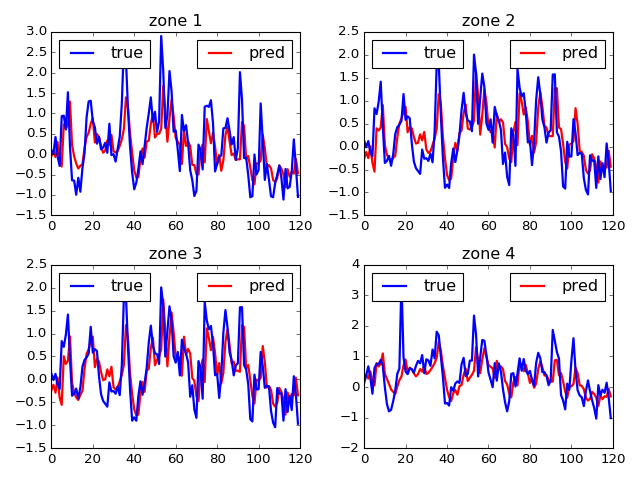

In [27]:
myplot(y, test_Y, 0)

<IPython.core.display.Javascript object>


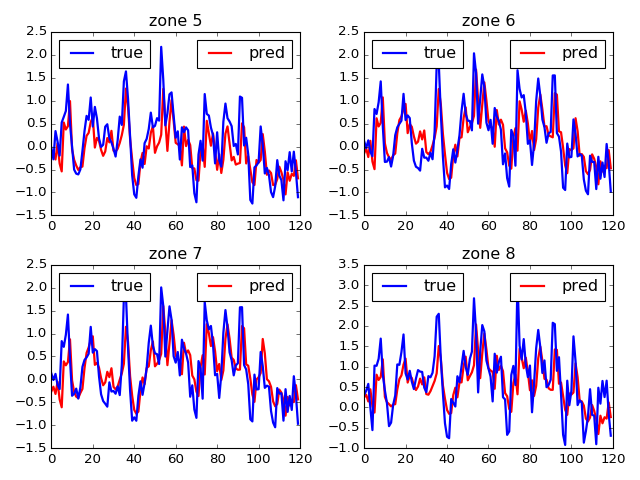

In [18]:
myplot(y, test_Y, 4)

<IPython.core.display.Javascript object>


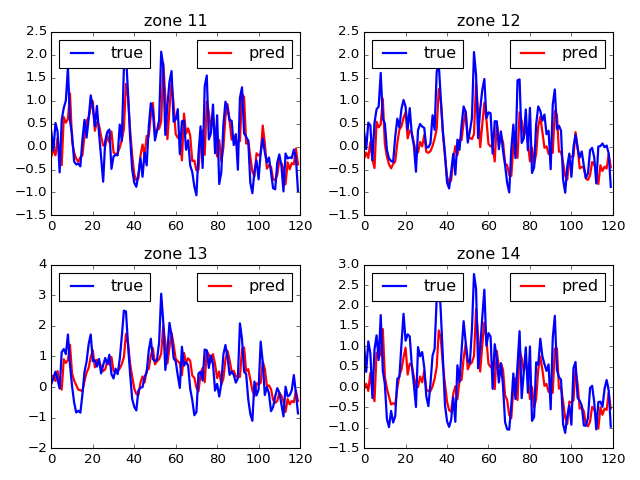

In [19]:
myplot(y, test_Y, 10)

<IPython.core.display.Javascript object>


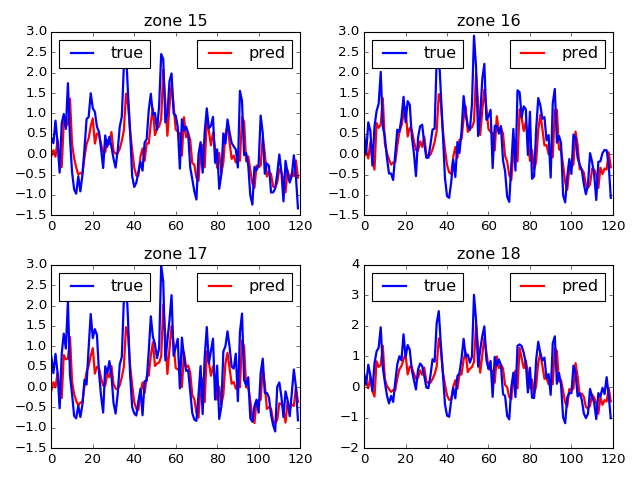

In [20]:
myplot(y, test_Y, 14)